<a href="https://colab.research.google.com/github/charlesncn/Tweeter-BOT/blob/main/bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk

In [ ]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('all')
import pycountry
import re
import string

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from google.colab import files
uploaded = files.upload()

cred_txt = 'me.txt'

Saving me.txt to me (1).txt


In [ ]:
cred = uploaded[cred_txt].decode('utf-8').split('\n')

def get_cred(credentials):
  cred_dict = {}
  for line in range(5):
    cred_dict[cred[line].split('=')[0]] = cred[line].split('=')[1]
  return cred_dict[credentials]


In [ ]:
api_key = get_cred('api')
api_secret = get_cred('api_secret')
access_token = get_cred('access_token')
access_token_secret = get_cred('access_token_secret')

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

try:
  api.verify_credentials()
  print('OK')
except:
  print('Nope')

OK


In [ ]:
# Getting tweets with keyboard or hashtag
# Sentiment analysis

def percentage(p, w):
  return 100 * float(p)/float(w)

keyword = input("Keyword or hashtag to search: ")
no_of_tweets = int(input('Numbe rof tweets of search: '))

tweets = tweepy.Cursor(api.search, q=''+keyword+' -filter:retweets').items(no_of_tweets)

positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list =[]

for tweet in tweets:
  tweet_list.append(tweet.text)
  analysis = TextBlob(tweet.text)
  score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)

  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  polarity += analysis.sentiment.polarity

  if neg > pos:
    negative_list.append(tweet.text)
    negative += 1

  elif pos > neg:
    positive_list.append(tweet.text)
    positive += 1

  elif pos == neg:
    neutral_list.append(tweet.text)
    neutral += 1

positive = percentage(positive, no_of_tweets)
negative = percentage(negative, no_of_tweets)
neutral = percentage(neutral, no_of_tweets)
polarity = percentage(polarity, no_of_tweets)

positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Keyword or hashtag to search: election kenya
Numbe rof tweets of search: 2000


In [ ]:
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number of tweets scraped: ',len(tweet_list))
print('positive tweets: ' +str(len(positive_list))+' ('+str(positive)+'%)')
print('negative tweets: ' +str(len(negative_list))+' ('+str(negative)+'%)')
print('neutral tweets: ' +str(len(neutral_list))+' ('+str(neutral)+'%)')

total number of tweets scraped:  1238
positive tweets: 478 (23.9%)
negative tweets: 313 (15.7%)
neutral tweets: 447 (22.4%)


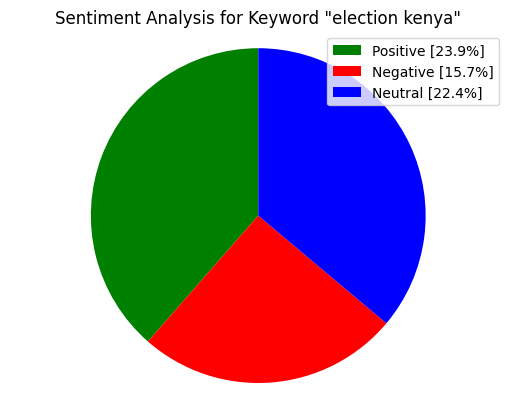

In [ ]:
# visualizing the data

labels = ['Positive ['+str(positive)+'%]', 'Negative ['+str(negative)+'%]', 'Neutral ['+str(neutral)+'%]']
sizes = [positive, negative, neutral]
colors = ['green', 'red', 'blue']
patches, text = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis for Keyword "'+keyword+'"')
plt.axis('equal')
plt.show()

In [ ]:
tweet_list

In [ ]:
# Do some data cleaning

tweet_list.drop_duplicates(inplace = True)
tweet_list

In [ ]:

# Creating new data frame from existing tweet list
new_tweet_list = pd.DataFrame(tweet_list)
new_tweet_list["text"] = new_tweet_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ',"",x)
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([0-9A-Za-z \t])|(\w+:\/\/\S+)","",x)

new_tweet_list["text"] = new_tweet_list.text.map(remove_rt).map(rt)
new_tweet_list["text"] = new_tweet_list.text.str.lower()

tweet_list.head(10)



In [ ]:
# Clean textxt
new_tweet_list = pd.DataFrame(tweet_list)

new_tweet_list["text"] = new_tweet_list[0]

def clean_tweet_list(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # removing mentions
  text = re.sub(r'#', '', text) # removing hashtags
  text = re.sub(r'https?:\/\/\S+', '', text) #remove links
  text = re.sub(r'_', '', text)
  return(text)

new_tweet_list['text'] = new_tweet_list['text'].apply(clean_tweet_list)

new_tweet_list

In [ ]:
new_tweet_list[['polarity', 'subjectivity',]] = new_tweet_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in new_tweet_list['text'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']

  if neg > pos:
    new_tweet_list.loc[index, 'sentiment'] = "negative"

  elif pos > neg:
    new_tweet_list.loc[index, 'sentiment'] = "positive"

  else:
    new_tweet_list.loc[index, 'sentiment'] = "neutral"

  new_tweet_list.loc[index, 'neg'] = neg
  new_tweet_list.loc[index, 'neu'] = neu
  new_tweet_list.loc[index, 'pos'] = pos
  new_tweet_list.loc[index, 'compound'] = comp

new_tweet_list.head(10)

In [ ]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_neg = new_tweet_list[new_tweet_list['sentiment']=='negative']
tweet_list_neu = new_tweet_list[new_tweet_list['sentiment']=='neutral']
tweet_list_pos = new_tweet_list[new_tweet_list['sentiment']=='positive']

In [ ]:
from locale import normalize
# function to count values in a column
def count_val(data,feature):
 total = data.loc[:,feature].value_counts(dropna=False)
 percentage = round(data.loc[:,feature].value_counts(dropna = False,normalize = True) * 100, 2)
 return pd.concat([total,percentage], axis = 1, keys = ['Total','Percentage'])
#Count_values for sentiment
count_val(new_tweet_list,'sentiment')

,Total,Percentage
positive,478,38.77
neutral,442,35.85
negative,313,25.39


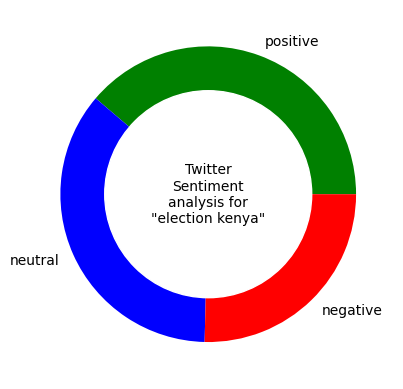

In [ ]:
# Create chard for that data

pichart = count_val(new_tweet_list, 'sentiment')
names = pichart.index
size = pichart['Percentage']
# Creating circle at the center of the chart
cen_circle = plt.Circle( (0,0), 0.7, color="white")
plt.pie(size, labels=names, colors = ['green', 'blue', 'red'])
plt.text(0,0, 'Twitter\nSentiment\nanalysis for\n"'+keyword+'"', ha='center', va='center')
p = plt.gcf()
p.gca().add_artist(cen_circle)
plt.show()

In [ ]:
from numpy.ma.core import repeat
# Funtion to create word cloud

def get_wordcloud(text):
 mask = np.array(Image.open('cloud.png'))
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color='white',
 mask = mask,
 max_words=3000,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 wc.to_file('wc.png')
 print('Word Cloud Saved Successfully')
 path='wc.png'
 display(Image.open(path))

Word Cloud Saved Successfully


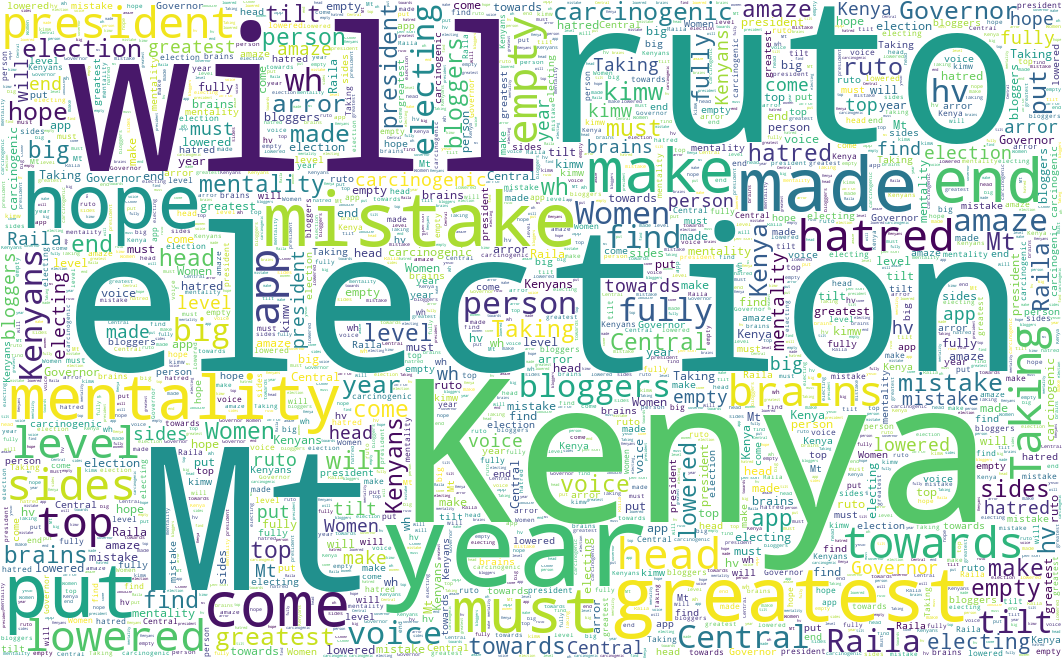

In [ ]:
get_wordcloud(new_tweet_list['text'].values)